In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
data_dst = 'data'
fig_dst = 'figures'

In [2]:
train_X = pd.read_csv(os.path.join(data_dst, 'train_X.csv'))
train_y = pd.read_csv(os.path.join(data_dst, 'train_y.csv'), header=None, squeeze=True)
test_X = pd.read_csv(os.path.join(data_dst, 'test_X.csv'))
test_y = pd.read_csv(os.path.join(data_dst, 'test_y.csv'), header=None, squeeze=True)

## Perform EDA and preprocess data before modeling

Take a look at the count of positive and negative classes in both training and test sets.

In [3]:
y = pd.DataFrame({'label': train_y, 'dataset': 'train'})
y = y.append(pd.DataFrame({'label': test_y, 'dataset': 'test'}), ignore_index=True)

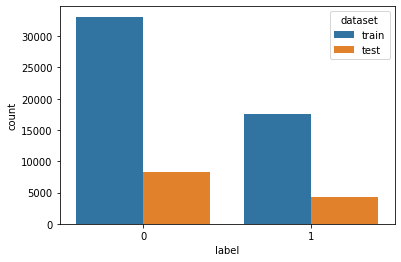

In [4]:
ax = sns.countplot(x='label', hue='dataset', data=y)
ax.figure.savefig(os.path.join(fig_dst, 'label_count.png'), dpi=300)

The ratio between negative and positive labels is approximately 2:1 in both training and test sets, i.e., the data is not highly imbalanced. In this case, accuracy alone is good enough to measure the model performance.

From here on, the test set will be set aside and all the exploration and modeling will be performed on the training set solely, until the final step - evaluating model performance. 

In [5]:
train_X.columns

Index(['reward', 'difficulty', 'duration', 'channel_web', 'channel_mobile',
       'channel_social', 'type_bogo', 'type_discount', 'type_informational',
       'age', 'income', 'profile_nan', 'days_as_member', 'gender_F',
       'gender_M', 'gender_O', 'gender_U'],
      dtype='object')

All features can be grouped into two types, binary (0, 1) labeled or numerical. 

Visualize the distribution and pair relationship of numerical columns. 

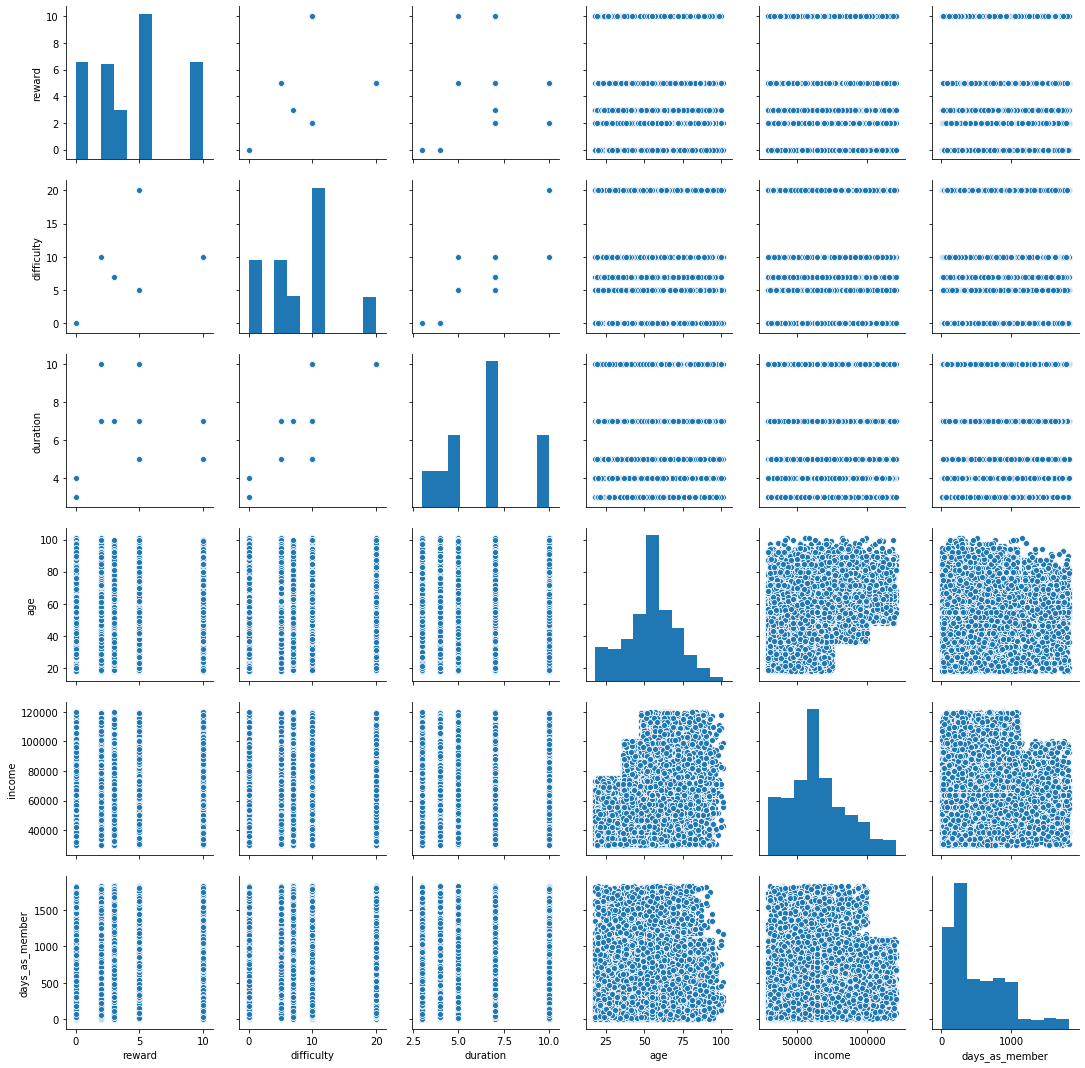

In [6]:
axes = sns.pairplot(train_X[['reward', 'difficulty', 'duration', 'age', 'income', 'days_as_member']])
axes.savefig(os.path.join(fig_dst, 'num_feature_pair.png'), dpi=300)

All the offer attributes are discrete. On the other hand, all the customer attributes are continuous. Other than a few clear orthogonal boundaries, no clear correlation can be observed between any pair of customer attributes. 

Implement `NumericalTransformer` to preprocess numerical columns. The discrete ones are scaled using `MinMaxScaler`, while the continuous ones are scaled using `StandardScaler`. Both scalers are implemented in scikit-learn. This preprocessing step is only necessary if the algorithm is distance based, such as support vector machine or regularized linear model. Not required for decision tree based algorithms. 

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, StandardScaler

class NumericalTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, discrete_columns=['reward', 'difficulty', 'duration'],
                 continuous_columns=['age', 'income', 'days_as_member']):
        self.discrete_columns = discrete_columns
        self.continuous_columns = continuous_columns
        self.discrete_scaler = MinMaxScaler()
        self.continuous_scaler = StandardScaler()
        
    def _get_discrete_columns(self, X):
        return X[self.discrete_columns]
    
    def _get_continuous_columns(self, X):
        return X[self.continuous_columns]
        
    def fit(self, X, y=None):
        self.discrete_scaler.fit(self._get_discrete_columns(X))
        self.continuous_scaler.fit(self._get_continuous_columns(X))
        return self
    
    def transform(self, X, y=None):
        X_discrete = self.discrete_scaler.transform(self._get_discrete_columns(X))
        X_continuos = self.continuous_scaler.transform(self._get_continuous_columns(X))
        X_binary = X.drop(columns=self.discrete_columns + self.continuous_columns)
        return np.hstack([X_binary, X_discrete, X_continuos])

## Select optimal algorithm

Use out-of-the-box classifiers to select optimal classification algorithm. The score is taken from the mean of 5-fold cross validation accuracy.

In [8]:
from sklearn.linear_model import LogisticRegression
logistic = make_pipeline(NumericalTransformer(), LogisticRegression())
cross_val_score(logistic, train_X, train_y, scoring='accuracy', cv=5, n_jobs=-1).mean()

0.7365592954908515

In [9]:
from sklearn.svm import LinearSVC
svm = make_pipeline(NumericalTransformer(), LinearSVC(dual=False))
cross_val_score(svm, train_X, train_y, scoring='accuracy', cv=5, n_jobs=-1).mean()

0.7346828966249379

In [10]:
from sklearn.ensemble import RandomForestClassifier
cross_val_score(RandomForestClassifier(n_estimators=100), train_X, train_y, scoring='accuracy', cv=5, n_jobs=-1).mean()

0.736381558671843

In [11]:
from lightgbm import LGBMClassifier
cross_val_score(LGBMClassifier(), train_X, train_y, scoring='accuracy', cv=5, n_jobs=-1).mean()

0.7637567343733975

Gradient tree boosting is the winner.

## Tune hyperparameters

Tuning hyperparameters for gradient tree boosting itself is a high dimensional problem. Here I break it down to a few steps of low dimensional grid search:

1. Keep a high `learning_rate` (0.1) until the final step. Find optimal parameters controlling the growth of an individual tree (`num_leaves` and `max_depth`).
2. Tune other parameters related to tree growth (`min_data_in_leaf` and `min_sum_hessian_in_leaf`).
3. Tune sampling parameters (`bagging_fraction` and `feature_fraction`).
4. Tune regularization parameters (`lambda_l1` and `lambda_l2`).
5. Try lowering `learning_rate` and more rounds of iterations to see if the score further improves. 

The entire process is leveraged on the cross validation API from LightGBM, with early stopping enabled and number of iterations returned. 

First, implement a method returning CV results for a `ParameterGrid`.

In [12]:
import lightgbm as lgb
from sklearn.model_selection import ParameterGrid

data_train = lgb.Dataset(train_X, train_y)

def get_cv_results(param_grid, learning_rate=0.1, n_iter=200, stop_ratio=0.1):
    """Returns CV results for a set of parameters.

    Args:
        param_grid: A sklearn ParameterGrid instance, or a list of dicts.
        learning_rate: Learning rate. Default to 0.1.
        n_iter: Maximum number of trees in the ensemble. Default to 200. 
            Scale it properly if learning rate changes.
        stop_ratio: Used to calculate early_stopping_rounds by 
            int(n_iter * stop_raio).

    Returns:
        A DataFrame with parameters and CV score. The score column is 
        sorted from low to high.

    """
    early_stopping_rounds = int(n_iter * stop_ratio)
    defaults = {'objective': 'binary', 'metrics': 'binary_error', 'learning_rate': learning_rate}
    all_results = pd.DataFrame()
    for params in param_grid:
        all_params = defaults.copy()
        all_params.update(params)
        cv_results = lgb.cv(all_params, data_train, num_boost_round=n_iter,
                            nfold=5, stratified=False, shuffle=False,
                            early_stopping_rounds=early_stopping_rounds)
        results = params.copy()
        results['score'] = cv_results['binary_error-mean'][-1]
        results['n_iter'] = len(cv_results['binary_error-mean'])
        all_results = all_results.append(results, ignore_index=True)
    return all_results.sort_values(['score'])

Then, follow the procedure. Start with a loose parameter grid, and close it in around the optimal parameters. Only the final round of grid search for each step is displayed as earlier rounds are overwritten. If the default value is optimal, the parameter will be removed from the input grid. 

In [13]:
# num_leaves, max_depth
pg = ParameterGrid({'num_leaves': [95, 103, 111, 119, 127, 135, 143, 151, 159],
                    'max_depth': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]})
get_cv_results(pg)

,max_depth,n_iter,num_leaves,score
40,14.0,98.0,127.0,0.234940
98,20.0,49.0,159.0,0.235098
3,10.0,84.0,119.0,0.235098
90,20.0,99.0,95.0,0.235414
93,20.0,68.0,119.0,0.235631
...,...,...,...,...
62,16.0,51.0,159.0,0.237863
32,13.0,38.0,135.0,0.238001
75,18.0,48.0,119.0,0.238001
26,12.0,39.0,159.0,0.238100


In [14]:
# min_data_in_leaf, min_sum_hessian
pg = ParameterGrid({'num_leaves': [127], 'max_depth': [14],
                    'min_data_in_leaf': [18, 19, 20, 21, 22],
                    'min_sum_hessian': [1e-4, 1e-3, 1e-2, 1e-1, 1]})
get_cv_results(pg)

,max_depth,min_data_in_leaf,min_sum_hessian,n_iter,num_leaves,score
12,14.0,20.0,0.0100,98.0,127.0,0.234940
13,14.0,20.0,0.1000,98.0,127.0,0.234940
11,14.0,20.0,0.0010,98.0,127.0,0.234940
10,14.0,20.0,0.0001,98.0,127.0,0.234940
18,14.0,21.0,0.1000,72.0,127.0,0.235414
17,14.0,21.0,0.0100,72.0,127.0,0.235414
16,14.0,21.0,0.0010,72.0,127.0,0.235414
15,14.0,21.0,0.0001,72.0,127.0,0.235414
14,14.0,20.0,1.0000,104.0,127.0,0.235750
24,14.0,22.0,1.0000,74.0,127.0,0.235789


In [15]:
# bagging_fraction, feature_fraction
pg = ParameterGrid({'num_leaves': [127], 'max_depth': [14],
                    'feature_fraction': [0.6, 0.7, 0.8, 0.9, 1.0], 
                    'bagging_fraction': [0.6, 0.7, 0.8, 0.9, 1.0],
                    'bagging_freq': [5]})
get_cv_results(pg)

,bagging_fraction,bagging_freq,feature_fraction,max_depth,n_iter,num_leaves,score
24,1.0,5.0,1.0,14.0,98.0,127.0,0.234940
22,1.0,5.0,0.8,14.0,94.0,127.0,0.234940
21,1.0,5.0,0.7,14.0,66.0,127.0,0.235809
19,0.9,5.0,1.0,14.0,100.0,127.0,0.235947
20,1.0,5.0,0.6,14.0,97.0,127.0,0.236125
17,0.9,5.0,0.8,14.0,46.0,127.0,0.236224
5,0.7,5.0,0.6,14.0,60.0,127.0,0.236243
6,0.7,5.0,0.7,14.0,67.0,127.0,0.236283
13,0.8,5.0,0.9,14.0,37.0,127.0,0.236401
15,0.9,5.0,0.6,14.0,31.0,127.0,0.236461


In [16]:
# lambda_l1, lambda_l2
pg = ParameterGrid({'num_leaves': [127], 'max_depth': [14],
                    'lambda_l1': [0, 1e-4, 1e-2, 1], 
                    'lambda_l2': [0, 1e-4, 1e-2, 1]})
get_cv_results(pg)

,lambda_l1,lambda_l2,max_depth,n_iter,num_leaves,score
0,0.0000,0.0000,14.0,98.0,127.0,0.234940
5,0.0001,0.0001,14.0,88.0,127.0,0.235631
15,1.0000,1.0000,14.0,88.0,127.0,0.235710
6,0.0001,0.0100,14.0,76.0,127.0,0.235888
1,0.0000,0.0001,14.0,60.0,127.0,0.235947
4,0.0001,0.0000,14.0,67.0,127.0,0.236184
3,0.0000,1.0000,14.0,56.0,127.0,0.236263
10,0.0100,0.0100,14.0,58.0,127.0,0.236263
2,0.0000,0.0100,14.0,49.0,127.0,0.236401
9,0.0100,0.0001,14.0,84.0,127.0,0.236599


The results from the first four steps suggest the tree growth parameters, `num_leaves` and `max_depth`, are critical with room to improve upon tuning. Once these settled, the default values for the rest parameters are already optimal. 

In [17]:
pg = ParameterGrid({'num_leaves': [127], 'max_depth': [14]})

Finally, the learning rate. 

In [18]:
get_cv_results(pg, learning_rate=0.1, n_iter=200)

,max_depth,n_iter,num_leaves,score
0,14.0,98.0,127.0,0.23494


In [19]:
get_cv_results(pg, learning_rate=0.01, n_iter=2000)

,max_depth,n_iter,num_leaves,score
0,14.0,844.0,127.0,0.235848


In [20]:
get_cv_results(pg, learning_rate=0.005, n_iter=4000)

,max_depth,n_iter,num_leaves,score
0,14.0,958.0,127.0,0.23727


Lowering learning rate does not further improve the score. Hence, here is the final optimal model with fine-tuned hyperparameters.

In [21]:
lgbm = LGBMClassifier(num_leaves=127, max_depth=14, n_estimators=98)

## Evaluate performance

Train both benchmark and optimal models on the entire training set, and evaluate their performance on the test set.

In [22]:
logistic.fit(train_X, train_y)
lgbm.fit(train_X, train_y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=14,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=98, n_jobs=-1, num_leaves=127, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [23]:
from sklearn.metrics import accuracy_score

print('Accuracy')
print('Benchmark model: %f' % accuracy_score(logistic.predict(test_X), test_y))
print('Optimal model: %f' % accuracy_score(lgbm.predict(test_X), test_y))

Accuracy
Benchmark model: 0.737399
Optimal model: 0.766472


Validate model robustness by shuffling training and test set with various random states. 

In [24]:
all_data = pd.read_csv(os.path.join(data_dst, 'all_data.csv'))
y = all_data['positive_response'].astype(int)
X = all_data.drop(columns=['positive_response'])

In [25]:
from sklearn.model_selection import train_test_split

scores = []
for seed in [8, 24, 13, 10, 41, 35, 7, 30]:
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=seed)
    lgbm.fit(train_X, train_y)
    lgbm_y = lgbm.predict(test_X)
    scores.append(accuracy_score(lgbm.predict(test_X), test_y))
scores

[0.7622847211249802,
 0.7657607836941065,
 0.7595986727761099,
 0.7721598988781798,
 0.7664717964923369,
 0.7639437509875178,
 0.7649707694738506,
 0.7659977879601833]

The accuracy score remains stable regardless of how the dataset splits, suggesting the solution is robust.